In [1]:
import pickle
import json

import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, utils, decomposition, model_selection, linear_model, discriminant_analysis, svm, tree, ensemble

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import matplotlib.pyplot as plt


In [2]:
data = None

with open('full_factorial/all_experiments_full_factorial.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
configs = None

with open('full_factorial/experiment_data_with_id_full_factorial.json') as f:
    configs = json.load(f)

In [4]:
configs_df = pd.read_csv('full_factorial/full_factorial_configs_as_df.csv')


## Actual analysis

### Power calculation

In [5]:
# TDP/core

# Skylake, Broadwell, Haswell, AMD EPYC Rome, and AMD EPYC Milan
# 6700: 65/4, 5775c: 65/8, 4770:  84/4, EPYC 7352: 155/24, EPYC 7443: 200/24

tdp_per_core = sum([65/4, 65/8, 84/4, 155/24, 200/24]) / 5

tdp_per_core

12.033333333333335

### Plot loaded data

In [6]:
columns_to_plot = list(data[list(data.keys())[0]].columns)

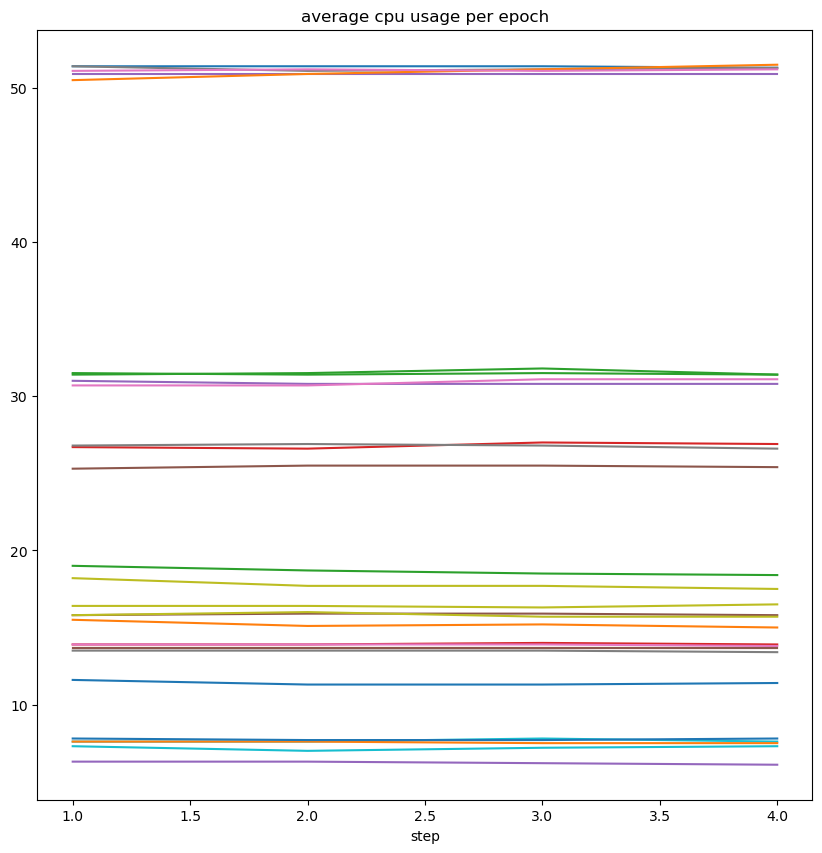

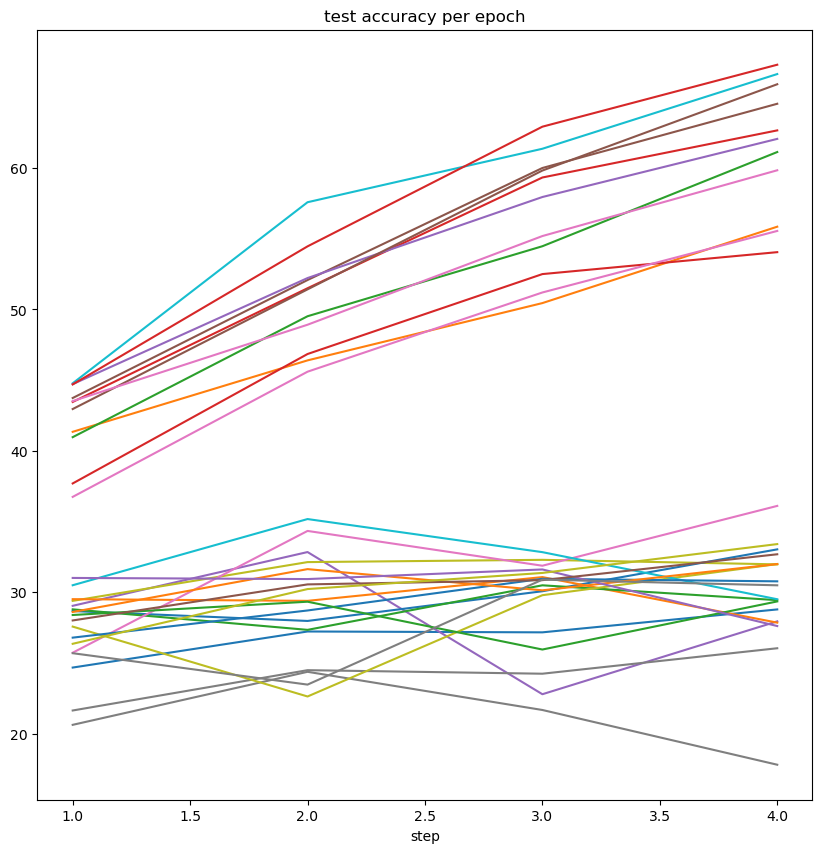

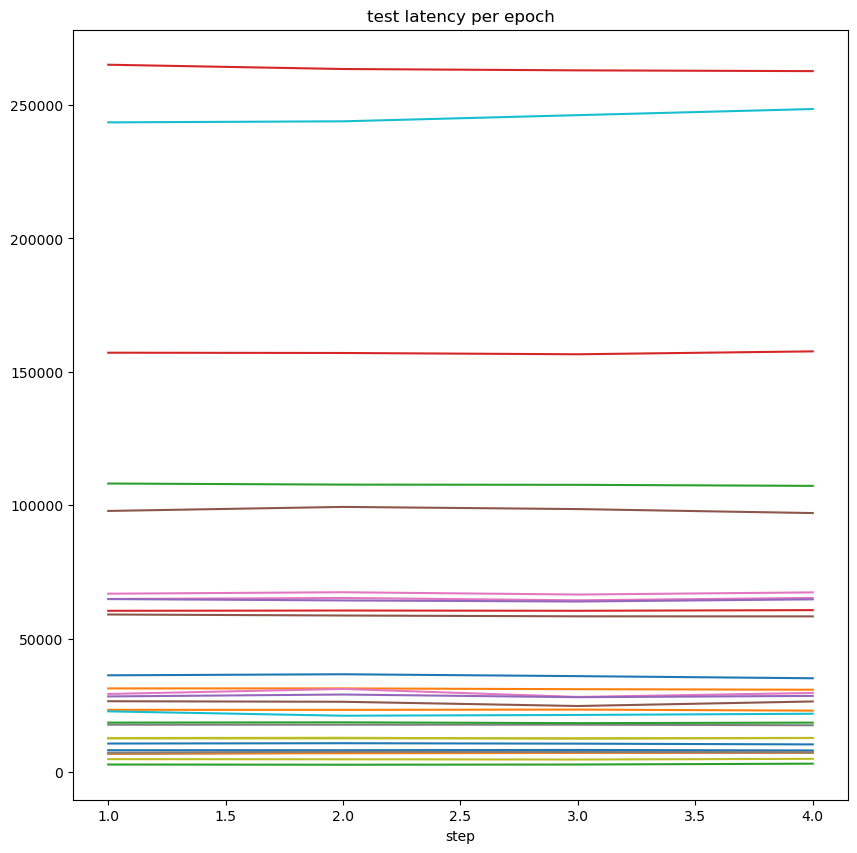

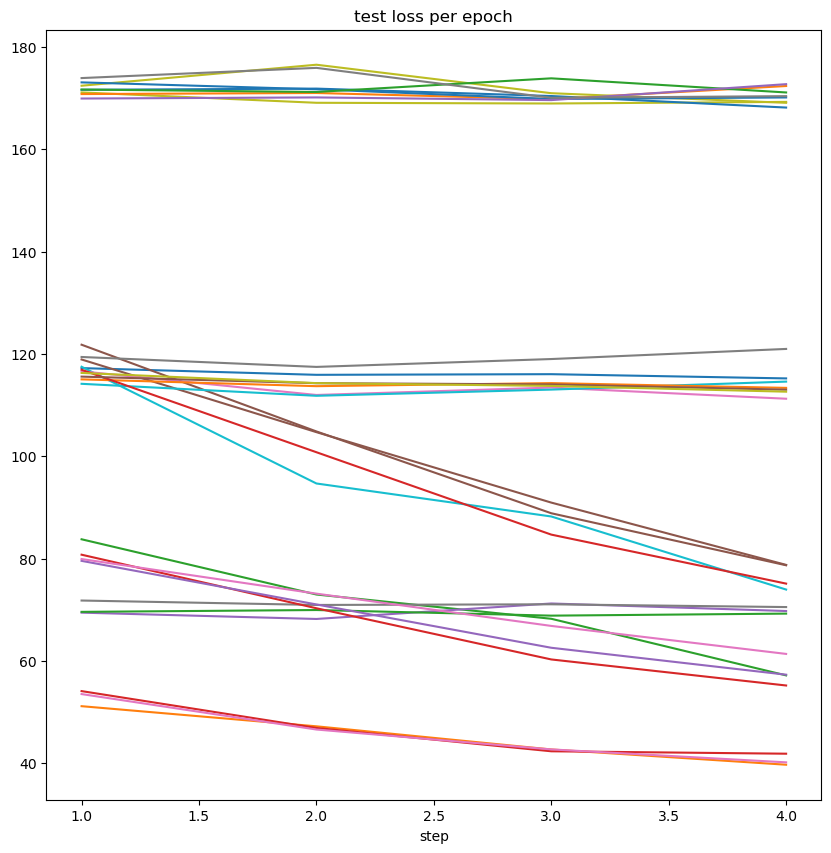

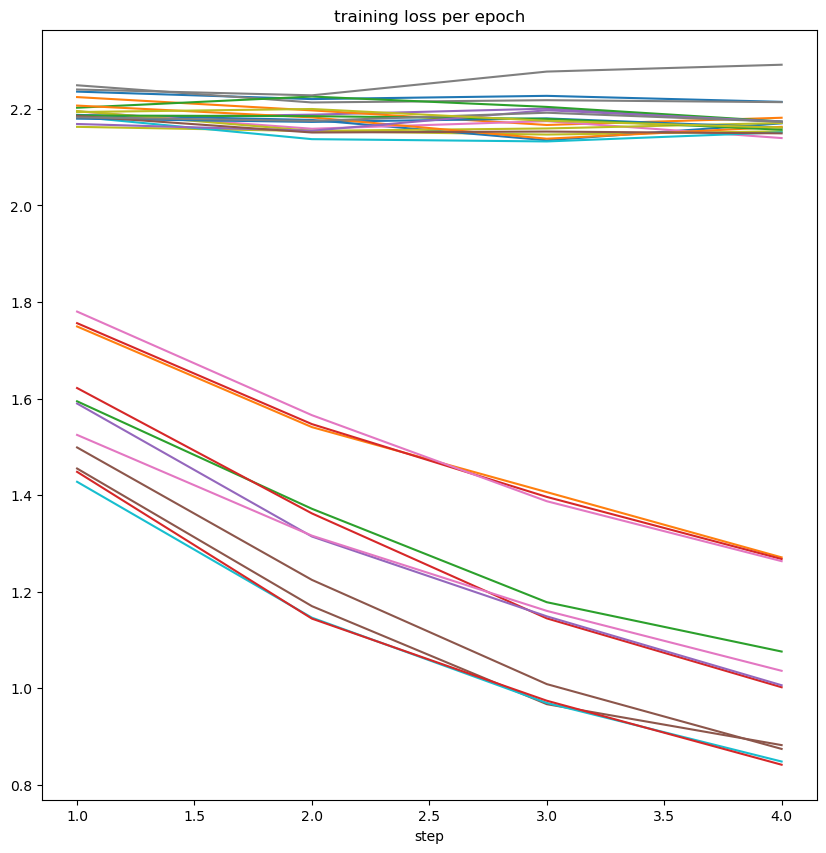

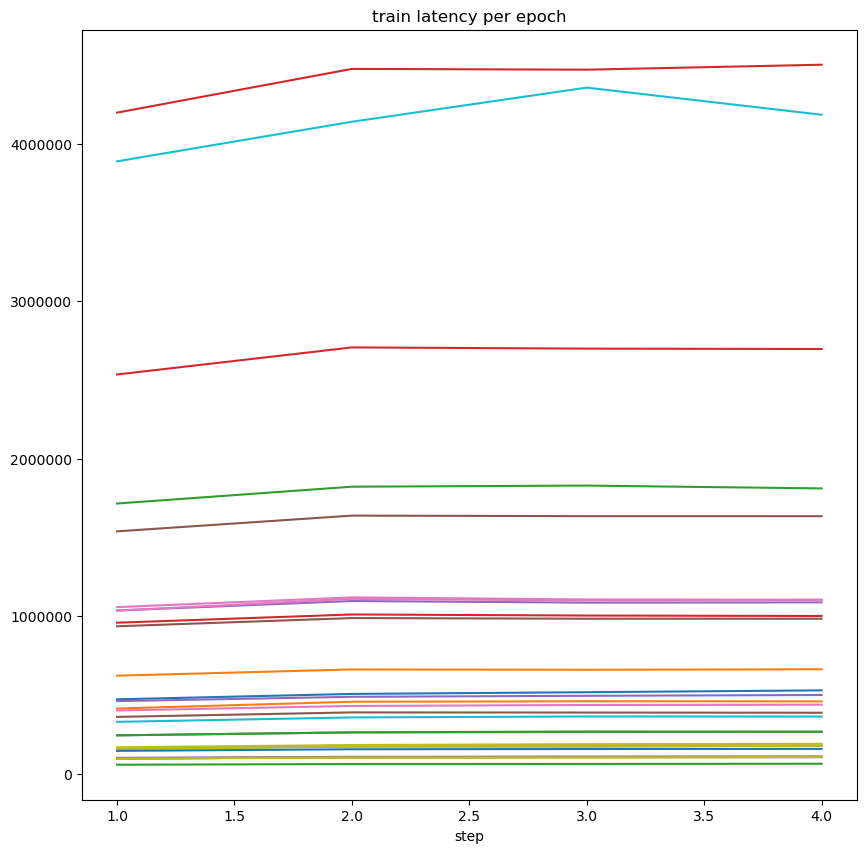

In [7]:
for column in columns_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    for key in data:
        data[key].plot(x=None, y=column, title=key, ax=ax, legend=False)

    plt.title(column)
    plt.show()

### Setup

In [8]:
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = preprocessing.StandardScaler().fit(X, y)

    # ... and scale the features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [56]:
from re import X


CNN = "Cifar10CNN" # Cifar10ResNet
ResNet = "Cifar10ResNet"

network_data_CNN = configs_df[configs_df['model'] == CNN]
network_data_ResNet = configs_df[configs_df['model'] == ResNet]
network_data_combined = configs_df



In [142]:
# UPDATE HERE THE COLUMNS YOU WANT TO USE FOR THE FITTING
X_CNN = network_data_CNN[[
    # 'model',
#  'batch_size',
#  'test_batch_size',
 'Paralell',
#  'Memory',
 'CPU',
 ]]

X_ResNet = network_data_ResNet[[
    # 'model',
#  'batch_size',
#  'test_batch_size',
 'Paralell',
#  'Memory',
 'CPU',
 ]]

X_combined = network_data_combined[[
    'model',
#  'batch_size',
#  'test_batch_size',
 'Paralell',
#  'Memory',
 'CPU',
 ]]

maskCNN = X_combined.model == 'Cifar10CNN'
maskResNet = X_combined.model == 'Cifar10ResNet'
X_combined.loc[maskCNN, 'model'] = 1
X_combined.loc[maskResNet, 'model'] = 2

# UPDATE HERE THE COLUMN THAT YOU WANT TO PREDICT
# y_CNN = network_data_CNN['mean train latency per epoch'] + network_data_CNN['mean test latency per epoch']  #Sum of latencies is service time
# y_ResNet = network_data_ResNet['mean train latency per epoch'] + network_data_ResNet['mean test latency per epoch']  #Sum of latencies is service time
# y_combined = network_data_combined['mean train latency per epoch'] + network_data_combined['mean test latency per epoch']  #Sum of latencies is service time

y_CNN = network_data_CNN['mean cpu usage per epoch']
y_ResNet = network_data_ResNet['mean cpu usage per epoch'] 
y_combined = network_data_combined['mean cpu usage per epoch']

### Linear regression (basic, no optimization)

In [164]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('R2: \n', regr.score(X, y))

Intercept: 
 -80478.3681540484
Coefficients: 
 [ 557761.62988463  -35750.54193804 -246979.87350571]
R2: 
 0.7132893105298437


### Hyperparam search

In [143]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = prepare_data(X_CNN, y_CNN)
X_train_ResNet, X_test_ResNet, y_train_ResNet, y_test_ResNet = prepare_data(X_ResNet, y_ResNet)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = prepare_data(X_combined, y_combined)

In [ ]:

opt = BayesSearchCV(
    ensemble.RandomForestRegressor(),
    {
        # 'bootstrap': [True, False],
        # 'max_depth': Integer(10,20),
        # 'max_features': ["sqrt", "log2", None],
        # 'min_samples_leaf': Integer(10,20),
        # 'min_samples_split': Integer(10,20),
        'n_estimators': Integer(1,150)
    },
    # error_score=0.0,
    n_iter=16,
    cv=5,
    verbose=5
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

# Print best params
print("best params: %s" % str(opt.best_params_))



In [155]:
%%capture
from statistics import mean
from sklearn import ensemble
from ray import air, tune
from ray.tune.sklearn import TuneGridSearchCV
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneSearchCV
import random
best = []
for (X_train, y_train, X_test, y_test) in [(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN), (X_train_ResNet, y_train_ResNet, X_test_ResNet, y_test_ResNet), (X_train_combined, y_train_combined, X_test_combined, y_test_combined)]:
    def trainrf(config):
        accuracies = 0
        for i in range(10):
            rf = ensemble.RandomForestRegressor(
                bootstrap=config["bootstrap"], 
                max_depth=config["max_depth"], 
                max_features=config["max_features"], 
                min_samples_leaf=config["min_samples_leaf"],
                min_samples_split=config["min_samples_split"],
                n_estimators=config["n_estimators"]).fit(X_train, y_train)
            accuracies += rf.score(X_test, y_test)
        # feature_importances = rf.feature_importances_
        tune.report(mean_accuracy=accuracies/10)

    # [bootstrap, max depth, max features, min samples leaf, min samples split,n estimators]
    parameter_grid = {
        "bootstrap": tune.choice([True]), 
        "max_depth": tune.grid_search([1,2,3,4,5,6,7,8,9,10, None]), 
        "max_features": tune.grid_search(["sqrt", "log2", None]), 
        "min_samples_leaf": tune.choice([tune.randint(1,10), tune.uniform(0, 10)]), 
        "min_samples_split": tune.choice([tune.randint(2,10), tune.uniform(0, 1)]), 
        "n_estimators": tune.grid_search(np.arange(1, 100))
        }

    tuner_rf = tune.Tuner(
        trainrf,
        param_space=parameter_grid,
    )
    results = tuner_rf.fit()
    best_result_rf = results.get_best_result(metric="mean_accuracy", mode='max')
    best.append(best_result_rf)

Trial name,status,loc,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,acc,iter,total time (s)
trainrf_2afba_00001,RUNNING,192.168.1.66:364523,True,2,sqrt,2.17785,0.442262,85,,,
trainrf_2afba_00002,RUNNING,192.168.1.66:364526,True,3,sqrt,9.92153,0.361821,48,,,
trainrf_2afba_00003,RUNNING,192.168.1.66:364527,True,4,sqrt,5.49039,0.889856,7,,,
trainrf_2afba_00004,RUNNING,192.168.1.66:364529,True,5,sqrt,6,7,38,,,
trainrf_2afba_00005,RUNNING,192.168.1.66:364533,True,6,sqrt,1,5,88,,,
trainrf_2afba_00006,RUNNING,192.168.1.66:364535,True,7,sqrt,5.20074,0.269573,48,,,
trainrf_2afba_00007,RUNNING,192.168.1.66:364536,True,8,sqrt,8.85273,5,67,,,
trainrf_2afba_00008,RUNNING,192.168.1.66:364396,True,9,sqrt,2,4,74,-0.112194,1,4.22926
trainrf_2afba_00009,PENDING,,True,10,sqrt,4.28497,6,72,,,
trainrf_2afba_00010,PENDING,,True,,sqrt,7,3,25,,,


Result for trainrf_2afba_00000:
  date: 2022-10-30_20-58-11
  done: false
  experiment_id: c64a590b37fc4a99b4b96612beb1708a
  hostname: hugo-VivoBook-ASUSLaptop-X431FL-S431FL
  iterations_since_restore: 1
  mean_accuracy: -0.6233573400462319
  node_ip: 192.168.1.66
  pid: 364396
  time_since_restore: 1.1326279640197754
  time_this_iter_s: 1.1326279640197754
  time_total_s: 1.1326279640197754
  timestamp: 1667159891
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2afba_00000
  warmup_time: 0.004685163497924805
  
Result for trainrf_2afba_00000:
  date: 2022-10-30_20-58-11
  done: true
  experiment_id: c64a590b37fc4a99b4b96612beb1708a
  experiment_tag: 0_bootstrap=True,max_depth=1,max_features=sqrt,min_samples_leaf=7,min_samples_split=4,n_estimators=26
  hostname: hugo-VivoBook-ASUSLaptop-X431FL-S431FL
  iterations_since_restore: 1
  mean_accuracy: -0.6233573400462319
  node_ip: 192.168.1.66
  pid: 364396
  time_since_restore: 1.1326279640197754
  time_this_iter_s: 1.132

2022-10-30 20:58:14,366	WARNING tune.py:686 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Result for trainrf_2afba_00008:
  date: 2022-10-30_20-58-15
  done: false
  experiment_id: c64a590b37fc4a99b4b96612beb1708a
  hostname: hugo-VivoBook-ASUSLaptop-X431FL-S431FL
  iterations_since_restore: 1
  mean_accuracy: -0.11219353408945669
  node_ip: 192.168.1.66
  pid: 364396
  time_since_restore: 4.229261159896851
  time_this_iter_s: 4.229261159896851
  time_total_s: 4.229261159896851
  timestamp: 1667159895
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2afba_00008
  warmup_time: 0.004685163497924805
  


2022-10-30 20:58:19,222	ERROR tune.py:754 -- Trials did not complete: [trainrf_2afba_00001, trainrf_2afba_00002, trainrf_2afba_00003, trainrf_2afba_00004, trainrf_2afba_00005, trainrf_2afba_00006, trainrf_2afba_00007, trainrf_2afba_00008, trainrf_2afba_00009, trainrf_2afba_00010, trainrf_2afba_00011, trainrf_2afba_00012, trainrf_2afba_00013, trainrf_2afba_00014, trainrf_2afba_00015, trainrf_2afba_00016, trainrf_2afba_00017, trainrf_2afba_00018, trainrf_2afba_00019, trainrf_2afba_00020, trainrf_2afba_00021, trainrf_2afba_00022, trainrf_2afba_00023, trainrf_2afba_00024]
2022-10-30 20:58:19,224	INFO tune.py:758 -- Total run time: 13.92 seconds (11.25 seconds for the tuning loop).
2022-10-30 20:58:19,225	WARNING tune.py:764 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


In [153]:
best

[Result(metrics={'mean_accuracy': 0.1991170280332002, 'done': True, 'trial_id': 'a5f06_00029', 'experiment_tag': '29_bootstrap=True,max_depth=8,max_features=None,min_samples_leaf=2,min_samples_split=3,n_estimators=95'}, error=None, log_dir=PosixPath('/home/hugo/ray_results/trainrf_2022-10-30_20-54-22/trainrf_a5f06_00029_29_bootstrap=True,max_depth=8,max_features=None,min_samples_leaf=2,min_samples_split=3,n_estimators=95_2022-10-30_20-54-33'))]

### Best config for CNN

#### service time

In [63]:
rfc = ensemble.RandomForestRegressor(bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=8)
rfc.fit(X_train_CNN, y_train_CNN)
print(rfc.score(X_test_CNN, y_test_CNN))

0.9087195023420626


#### CPU utilization

In [127]:
rfc = ensemble.RandomForestRegressor(bootstrap=True, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=9)
rfc.fit(X_train_CNN, y_train_CNN)
print(rfc.score(X_test_CNN, y_test_CNN))

1.0


### Best config for ResNet

#### service time

In [64]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=0.2501, n_estimators=47)
rfr.fit(X_train_ResNet, y_train_ResNet)
print(rfr.score(X_test_ResNet, y_test_ResNet))

0.9477421112419298


#### CPU utilization

In [131]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=0.2186, n_estimators=80)
rfr.fit(X_train_ResNet, y_train_ResNet)
print(rfr.score(X_test_ResNet, y_test_ResNet))

0.9739055555555554


## Best config for combined

#### service time

In [65]:
rf2 = ensemble.RandomForestRegressor(bootstrap=True, max_depth=9, max_features=None, min_samples_leaf=0.0390, min_samples_split=2, n_estimators=91)
rf2.fit(X_train_combined, y_train_combined)
print(rf2.score(X_test_combined, y_test_combined))

0.9578927341724045


#### CPU utilization

In [136]:
rf2 = ensemble.RandomForestRegressor(bootstrap=True, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1)
rf2.fit(X_train_combined, y_train_combined)
print(rf2.score(X_test_combined, y_test_combined))

1.0


## Boxplots

In [139]:
data_combined = []
data_CNN = []
data_ResNet = []

for i in range(200):
    rf2.fit(X_train_combined, y_train_combined)
    data_combined.append(rf2.score(X_test_combined, y_test_combined)*100)
    rfc.fit(X_train_CNN, y_train_CNN)
    data_CNN.append(rfc.score(X_test_CNN, y_test_CNN)*100)
    rfr.fit(X_train_ResNet, y_train_ResNet)
    data_ResNet.append(rfr.score(X_test_ResNet, y_test_ResNet)*100)


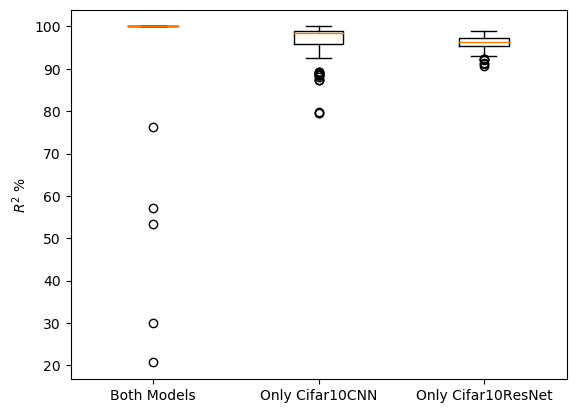

In [140]:
fig, ax = plt.subplots()
 
# Creating plot
ax.boxplot([data_combined, data_CNN, data_ResNet])

ax.set_xticklabels(["Both Models", "Only Cifar10CNN", "Only Cifar10ResNet"])
plt.ylabel("$R^2$ %")
 
# show plot
plt.savefig("boxplots_cpu.pdf")
plt.show()

ValueError: x and y must be the same size

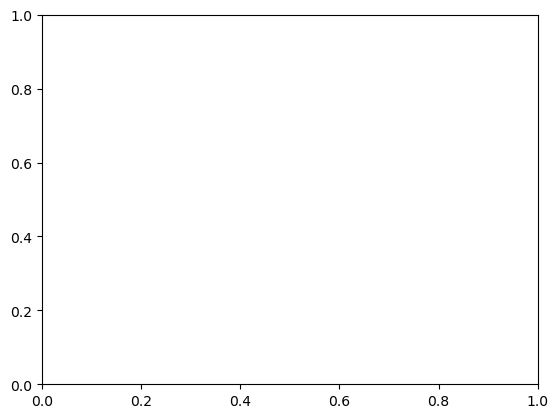

In [27]:
X_grid = np.arange(min(X_test[0]), max(X_test[0]), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(np.array(X), np.array(y), color = 'red')
plt.plot(X_grid, rf2.predict(X_grid), color = 'blue')
plt.title('Check It (Random Forest Regression Model)')
plt.xlabel('Position level')
plt.ylabel('Service time')
plt.show()